# Modelo de Valoración de Activos de Capital (CAPM) y Regresión Lineal

El **Capital Asset Pricing Model (CAPM)** es la piedra angular de la teoría moderna de portafolios. Establece una relación lineal entre el riesgo sistemático de una inversión y su rendimiento esperado.

### La Fórmula del CAPM
$$E[R_i] = R_f + \beta_i (E[R_m] - R_f)$$

Donde:
* $E[R_i]$: Retorno esperado del activo.
* $R_f$: Tasa libre de riesgo (Risk-Free Rate), usualmente Bonos del Tesoro de EE.UU.
* $\beta_i$: Sensibilidad del activo al mercado (Riesgo Sistemático).
* $E[R_m] - R_f$: Prima de riesgo del mercado (Market Risk Premium).



### El Enfoque de Regresión (Security Characteristic Line)
Para encontrar el $\beta$ (Beta) y el $\alpha$ (Alpha), utilizamos una regresión lineal de mínimos cuadrados ordinarios (OLS):

$$R_i - R_f = \alpha + \beta (R_m - R_f) + \epsilon$$

* **Variable Dependiente ($Y$):** Exceso de retorno del activo ($R_i - R_f$).
* **Variable Independiente ($X$):** Exceso de retorno del mercado ($R_m - R_f$).
* **Pendiente ($\beta$):** Riesgo de mercado.
* **Intercepto ($\alpha$):** Rendimiento anormal (Jensen's Alpha). Si el mercado es eficiente, $\alpha$ debería ser 0.

In [1]:
# === Instalación de librerías específicas ===
# Ejecutar si no se tienen instaladas
# !pip install pandas_datareader getFamaFrenchFactors yfinance plotly statsmodels

# === Importación de Módulos ===
import numpy as np
import pandas as pd
import datetime as dt

# Librerias de visualización
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px

# Librerias financieras y estadísticas
import yfinance as yf
import statsmodels.api as sm
import getFamaFrenchFactors as gff # Librería para obtener factores de riesgo académicos

# Configuración de estilo
plt.style.use('seaborn-v0_8-darkgrid')

## 1. Obtención de Datos de Mercado
Analizaremos la relación entre **Apple (AAPL)** y el mercado general representado por el índice **S&P 500 (^GSPC)**.
Trabajaremos con una frecuencia **mensual**, ya que el ruido diario puede distorsionar la relación beta a largo plazo.

In [2]:
# === Definición de Parámetros ===
tickers = ['AAPL', '^GSPC'] # Activo individual e Indice de Mercado
start_date = '2015-01-01'
end_date = '2018-01-01'

# === Descarga de Datos ===
# Descargamos ambos tickers a la vez para facilitar la sincronización
# 'Adj Close' es preferible a 'Close' porque ajusta por dividendos y splits
raw_data = yf.download(tickers, start=start_date, end=end_date,auto_adjust=False)['Adj Close']

# Renombramos columnas para facilitar el manejo
# Nota: yfinance descarga en orden alfabético, verificamos el orden
raw_data.columns = ['Inv_Close', 'Markt_Close'] # AAPL, ^GSPC

print("Datos descargados correctamente:")
print(raw_data.head())

# === Resampling (Frecuencia Mensual) ===
# Convertimos datos diarios a mensuales tomando el último precio del mes.
# 'ME' es el alias moderno para Month End (en versiones viejas de pandas usar 'M')
data_monthly = raw_data.resample('ME').last()

print("\nDatos Mensuales:")
print(data_monthly.head())

[*********************100%***********************]  2 of 2 completed

Datos descargados correctamente:
            Inv_Close  Markt_Close
Date                              
2015-01-02  24.237555  2058.199951
2015-01-05  23.554741  2020.579956
2015-01-06  23.556965  2002.609985
2015-01-07  23.887270  2025.900024
2015-01-08  24.805082  2062.139893

Datos Mensuales:
            Inv_Close  Markt_Close
Date                              
2015-01-31  25.973394  1994.989990
2015-02-28  28.590906  2104.500000
2015-03-31  27.693962  2067.889893
2015-04-30  27.854216  2085.510010
2015-05-31  29.117102  2107.389893


## 2. Cálculo de Retornos Logarítmicos
En modelos financieros continuos, preferimos los retornos logarítmicos sobre los aritméticos por sus propiedades de aditividad temporal y normalidad estadística.

$$r_t = \ln\left(\frac{P_t}{P_{t-1}}\right)$$

In [3]:
# Calcular retornos logarítmicos
# np.log(Precio_Actual / Precio_Anterior)
# shift(1) mueve los datos una posición hacia abajo para alinear t con t-1
data_returns = np.log(data_monthly / data_monthly.shift(1))

# Renombrar columnas a Retornos
data_returns.columns = ['Inv_Ret', 'Markt_Ret']

# Eliminar la primera fila que será NaN (no hay retorno previo para la primera fecha)
data_returns.dropna(inplace=True)

print(data_returns.head())

             Inv_Ret  Markt_Ret
Date                           
2015-02-28  0.096016   0.053439
2015-03-31 -0.031874  -0.017549
2015-04-30  0.005770   0.008485
2015-05-31  0.044341   0.010437
2015-06-30 -0.037938  -0.021236


## 3. Visualización de Correlación y Beta "Analítico"

Antes de la regresión, visualizamos la dispersión. Si el CAPM se cumple, deberíamos ver una clara tendencia positiva.
También podemos calcular el Beta usando la fórmula de covarianza (sin regresión):

$$\beta = \frac{Cov(R_i, R_m)}{Var(R_m)}$$

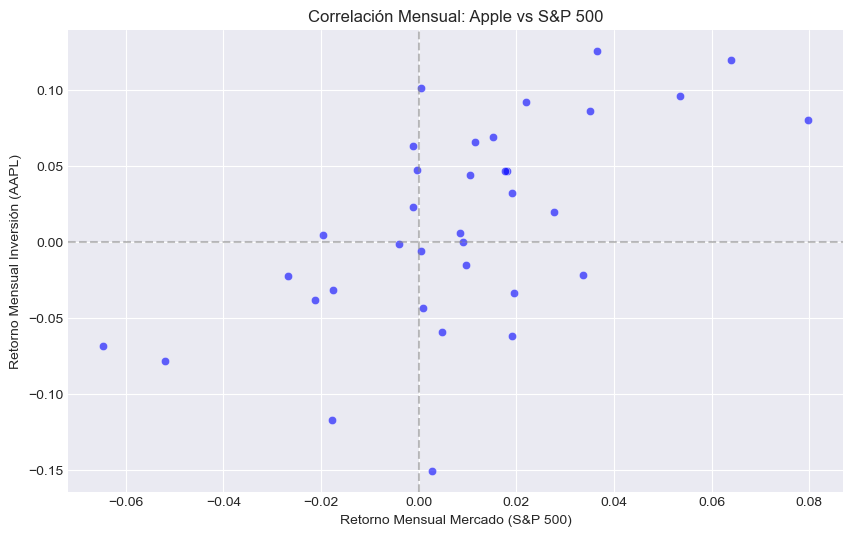

Beta calculado vía Covarianza/Varianza: 1.4373


In [4]:
# === Gráfico de Dispersión (Scatter Plot) ===
plt.figure(figsize=(10, 6))

# Líneas de referencia en 0
plt.axvline(0, color='grey', alpha=0.5, linestyle='--')
plt.axhline(0, color='grey', alpha=0.5, linestyle='--')

# Scatter plot con Seaborn
sns.scatterplot(x='Markt_Ret', y='Inv_Ret', data=data_returns, color='blue', alpha=0.6)

plt.title(f'Correlación Mensual: Apple vs S&P 500')
plt.xlabel('Retorno Mensual Mercado (S&P 500)')
plt.ylabel('Retorno Mensual Inversión (AAPL)')
plt.show()

# === Cálculo Matemático del Beta (Fórmula Covarianza) ===
covariance_matrix = data_returns.cov()
# La covarianza entre el activo y el mercado
cov_inv_mkt = covariance_matrix.loc['Inv_Ret', 'Markt_Ret']
# La varianza del mercado
var_mkt = data_returns['Markt_Ret'].var()

beta_formula = cov_inv_mkt / var_mkt

print(f'Beta calculado vía Covarianza/Varianza: {beta_formula:.4f}')

### Interpretación del Beta Analítico ($\beta \approx 1.44$)

El cálculo directo mediante la matriz de covarianza arroja un **Beta de 1.44**.

**Análisis Financiero:**
* **Sensibilidad Agresiva:** Al ser $\beta > 1$, Apple se comportó como un activo **agresivo** durante este periodo.
* **Elasticidad del Riesgo:** Un Beta de 1.44 implica que, teóricamente, si el mercado (S&P 500) sube un **1%**, se espera que Apple suba un **1.44%**. De igual forma, si el mercado cae un 1%, Apple sufriría una caída amplificada del 1.44%.
* **Riesgo Sistemático:** Este valor cuantifica el riesgo que **no se puede eliminar diversificando**. Es el precio que paga el inversor por la exposición a la volatilidad inherente de la economía (reflejada en el sector tecnológico).

## 4. Obtención de la Tasa Libre de Riesgo ($R_f$)

Para aplicar CAPM correctamente, no debemos usar retornos brutos, sino **Excesos de Retorno** ($R - R_f$).
Usaremos la librería de **Kenneth French** para obtener la tasa libre de riesgo histórica precisa y los factores de mercado oficiales.

*Fuente:* [Kenneth French Data Library](http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html)

In [5]:
# === Descarga de Factores Fama-French ===
# ff3_monthly contendrá: 'Mkt-RF' (Exceso de mercado), 'SMB', 'HML' y 'RF' (Risk Free)
ff3_monthly = pd.DataFrame(gff.famaFrench3Factor(frequency='m'))

# Renombrar columna de fecha para poder hacer el merge
ff3_monthly.rename(columns={'date_ff_factors': 'Date'}, inplace=True)
ff3_monthly.set_index('Date', inplace=True)

# Ajustar el índice al final del mes para que coincida con nuestros datos
# ff3 suele venir con fechas al inicio o final, estandarizamos a 'ME'
ff3_monthly.index = ff3_monthly.index + pd.offsets.MonthEnd(0)

print(ff3_monthly.head())

# === Fusión de Datos (Merge) ===
# Unimos nuestros retornos calculados con los factores oficiales por fecha
# Usamos 'inner' join para quedarnos solo con las fechas que existen en ambos lados
data_merge = pd.merge(data_returns, ff3_monthly, left_index=True, right_index=True, how='inner')

print("\nDataset Fusionado:")
print(data_merge.head())

            Mkt-RF     SMB     HML      RF
Date                                      
1926-07-31  0.0289 -0.0255 -0.0239  0.0022
1926-08-31  0.0264 -0.0114  0.0381  0.0025
1926-09-30  0.0038 -0.0136  0.0005  0.0023
1926-10-31 -0.0327 -0.0014  0.0082  0.0032
1926-11-30  0.0254 -0.0011 -0.0061  0.0031

Dataset Fusionado:
             Inv_Ret  Markt_Ret  Mkt-RF     SMB     HML   RF
Date                                                        
2015-02-28  0.096016   0.053439  0.0613  0.0061 -0.0179  0.0
2015-03-31 -0.031874  -0.017549 -0.0111  0.0305 -0.0038  0.0
2015-04-30  0.005770   0.008485  0.0059 -0.0299  0.0180  0.0
2015-05-31  0.044341   0.010437  0.0137  0.0095 -0.0111  0.0
2015-06-30 -0.037938  -0.021236 -0.0152  0.0294 -0.0082  0.0


## 5. Preparación para la Regresión: Excesos de Retorno

Ahora restamos la tasa libre de riesgo a nuestros retornos para aislar la prima por riesgo.
*Nota:* Los datos de Fama-French suelen venir en porcentajes (ej. 0.5 para 0.5%), mientras que nuestros logs returns están en decimales (0.005). Verificamos la escala (en este caso asumiremos que ajustamos RF a decimales dividiendo por 100 si es necesario, o nuestros retornos a porcentaje). **Para este ejercicio, asumiremos consistencia decimal.**

In [6]:
# Nota: Revisar la escala. Fama-French suele estar en decimales simples o porcentajes.
# Asumiremos que 'RF' viene en formato decimal (ej: 0.002 para 0.2%).

# Exceso de Retorno de la Inversión (Yi)
# Restamos la Tasa Libre de Riesgo (RF) al retorno de Apple
data_merge['Inv_Excess_Ret'] = data_merge['Inv_Ret'] - data_merge['RF']

# El Mercado (Mkt-RF) ya viene calculado en el dataset de Fama-French, 
# pero podemos comparar con el nuestro para validar.
# Usaremos 'Mkt-RF' provisto por Fama-French como la variable X estándar académica.

print(data_merge[['Inv_Excess_Ret', 'Mkt-RF']].head())

            Inv_Excess_Ret  Mkt-RF
Date                              
2015-02-28        0.096016  0.0613
2015-03-31       -0.031874 -0.0111
2015-04-30        0.005770  0.0059
2015-05-31        0.044341  0.0137
2015-06-30       -0.037938 -0.0152


## 6. Visualización de la Línea de Regresión (SCL)

Graficaremos la **Security Characteristic Line (SCL)**.
* **Eje X:** Exceso de Retorno del Mercado.
* **Eje Y:** Exceso de Retorno del Activo.
* **Pendiente:** Beta.
* **Sombra:** Intervalo de confianza del 95%.

Si la banda de confianza es estrecha, la estimación del Beta es precisa ($R^2$ alto).

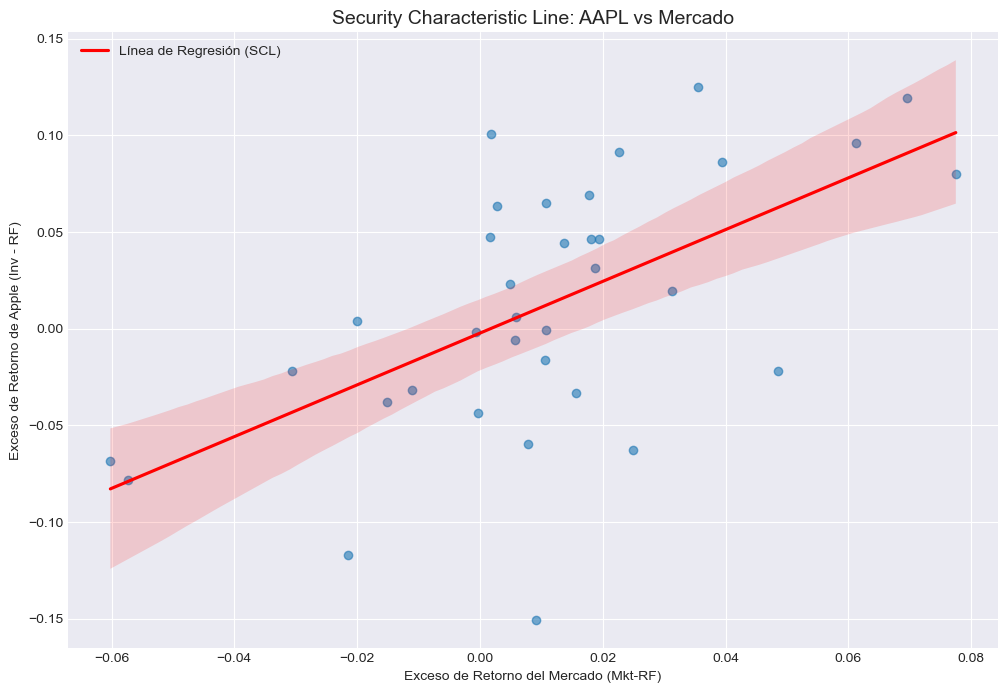

In [7]:
plt.figure(figsize=(12, 8))

# sns.regplot incluye la dispersión y la línea de ajuste automático
sns.regplot(x='Mkt-RF', y='Inv_Excess_Ret', data=data_merge, 
            scatter_kws={'alpha':0.6}, line_kws={'color':'red', 'label':'Línea de Regresión (SCL)'})

plt.title('Security Characteristic Line: AAPL vs Mercado', fontsize=14)
plt.xlabel('Exceso de Retorno del Mercado (Mkt-RF)')
plt.ylabel('Exceso de Retorno de Apple (Inv - RF)')
plt.legend()
plt.show()

### Interpretación Visual: La Línea Característica del Valor (SCL)

El gráfico anterior representa la **Security Characteristic Line (SCL)** de Apple.

**Lectura Económica y Estadística:**
1.  **Pendiente Positiva:** La línea roja ascendente confirma la correlación positiva. En una economía saludable (mercado subiendo a la derecha), Apple tiende a generar retornos positivos.
2.  **Dispersión (Riesgo Idiosincrático):** Los puntos azules no caen perfectamente sobre la línea roja; están dispersos alrededor de ella.
    * La distancia vertical entre cada punto y la línea roja son los **residuos** ($\epsilon$).
    * Esta dispersión representa el **Riesgo Idiosincrático** (Específico de la empresa). Son movimientos causados por noticias propias de Apple (lanzamiento de iPhone, reportes de ganancias, demandas) y no por la economía general.
3.  **Banda de Confianza:** La sombra alrededor de la línea roja nos muestra el intervalo de confianza del 95%. Al ser relativamente estrecha cerca del centro, tenemos alta certeza sobre el comportamiento promedio, aunque la certeza disminuye en los extremos (eventos de mercado muy raros).

## 7. Estimación del Modelo OLS (Ordinary Least Squares)

Ejecutamos la regresión formal para obtener los coeficientes y sus pruebas de significancia estadística (P-values).

### Interpretación de Resultados:
1.  **Coeficiente `Mkt-RF` ($\beta$):** Si $\beta > 1$, el activo es **agresivo** (más volátil que el mercado). Si $\beta < 1$, es **defensivo**.
2.  **Constante (`const` o $\alpha$):** Mide el rendimiento que no explica el mercado.
    * Si $p < 0.05$ y $\alpha > 0$: El activo batió al mercado (Buy).
    * Si $p > 0.05$: El $\alpha$ es estadísticamente cero (Mercado Eficiente).
3.  **$R^2$ (R-squared):** Porcentaje de la varianza del activo explicada por el mercado. Un $R^2$ bajo implica que el activo tiene mucho **riesgo idiosincrático** (propio de la empresa) no diversificado.

In [8]:
# 1. Definir Variables
y = data_merge['Inv_Excess_Ret'] # Variable Dependiente
x = data_merge['Mkt-RF']         # Variable Independiente

# 2. Añadir Constante (Intercepto / Alpha)
# Statsmodels no añade intercepto por defecto, debemos forzarlo.
x1 = sm.add_constant(x)

# 3. Ajustar Modelo
model = sm.OLS(y, x1)
results = model.fit()

# 4. Mostrar Resumen Estadístico
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:         Inv_Excess_Ret   R-squared:                       0.348
Model:                            OLS   Adj. R-squared:                  0.328
Method:                 Least Squares   F-statistic:                     17.63
Date:                Tue, 06 Jan 2026   Prob (F-statistic):           0.000191
Time:                        14:09:30   Log-Likelihood:                 53.054
No. Observations:                  35   AIC:                            -102.1
Df Residuals:                      33   BIC:                            -99.00
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0023      0.010     -0.236      0.8

# Análisis Profundo del Modelo de Regresión (OLS)

La tabla anterior es una radiografía estadística completa del modelo CAPM para Apple. A continuación, desglosamos los componentes críticos:

### A. Coeficientes (La Ecuación del CAPM)

1.  **`Mkt-RF` (Beta $\beta$): 1.3386**
    * **Lectura:** Este es el Beta ajustado por regresión. Difiere ligeramente del cálculo manual (1.43) debido a cómo OLS maneja los residuos y la constante, pero confirma la naturaleza agresiva del activo ($\beta > 1$).
    * **Significancia ($P>|t|$ = 0.000):** El *P-value* es prácticamente cero. Esto significa que existe una **relación estadística extremadamente fuerte** entre el mercado y Apple. Podemos afirmar con un 99.9% de confianza que el movimiento del mercado *causa* movimientos en Apple.

2.  **`const` (Alpha $\alpha$): -0.0023**
    * **Lectura (Alpha de Jensen):** Representa el retorno extra que obtuvo Apple *por encima* de lo esperado por su riesgo. Un valor negativo sugeriría que rindió menos de lo que debería dado su alto riesgo.
    * **Significancia ($P>|t|$ = 0.815):** **CRÍTICO.** El P-value es 0.815 (muy superior al umbral estándar de 0.05).
    * **Conclusión:** Estadísticamente, **el Alpha es igual a cero**. El valor de -0.0023 es ruido aleatorio. Esto apoya la **Hipótesis del Mercado Eficiente (EMH)**: Apple no generó retornos anormales sistemáticos; su rendimiento fue justa compensación por asumir un Beta de 1.33.

### B. Calidad del Ajuste (Bondad de Ajuste)

1.  **`R-squared` ($R^2$): 0.348**
    * **Lectura:** El factor de mercado explica el **34.8%** de la variabilidad en los retornos de Apple.
    * **Interpretación Financiera:** El 65.2% restante de los movimientos de Apple se deben a factores **específicos de la empresa** (Riesgo No Sistemático). Esto es típico en acciones individuales; un solo activo tiene mucho "ruido" propio que el mercado no explica. Si hiciéramos esto con un portafolio diversificado, el $R^2$ subiría al 80-90%.

2.  **`F-statistic`: 17.63 (Prob: 0.00019)**
    * Nos dice si el modelo en su conjunto es útil. Como la probabilidad es muy baja (< 0.05), confirmamos que usar el CAPM es significativamente mejor que simplemente usar el promedio histórico para predecir retornos.

### C. Análisis de los Residuos (Validación de Supuestos)

Para que la regresión sea válida, los errores (residuos) deben comportarse "bien":

1.  **Normalidad (`Jarque-Bera` = 4.917, Prob = 0.0855):**
    * La prueba de Jarque-Bera verifica si los errores siguen una distribución normal.
    * Como `Prob (JB)` > 0.05, **NO rechazamos** la hipótesis de normalidad.
    * **Conclusión:** Los residuos se distribuyen de forma suficientemente normal. El modelo es robusto.

2.  **Autocorrelación (`Durbin-Watson` = 2.615):**
    * Mide si el error de hoy depende del error de ayer. Un valor de 2 indica no autocorrelación.
    * Un valor de 2.6 indica una leve autocorrelación negativa, pero no es grave. En finanzas mensuales, esto es aceptable.

3.  **Kurtosis (3.880) y Skew (-0.806):**
    * **Kurtosis > 3:** Indica "colas pesadas" (Leptocurtosis). Los eventos extremos (sorpresas positivas o negativas grandes) ocurren con más frecuencia en Apple que en una distribución normal perfecta.
    * **Skew Negativo:** Hay un sesgo hacia la izquierda, lo que implica que las "sorpresas negativas" (caídas fuertes) han sido ligeramente más frecuentes o intensas que las subidas extremas en este periodo.

## 8. Cálculo del Retorno Esperado (Fórmula Final)

Con los parámetros estimados ($\beta$), aplicamos la fórmula CAPM para saber cuánto **debería** rendir Apple en un año normal, dado su riesgo.

$$E[R_{AAPL}] = R_f + \beta_{AAPL} \times (MarketPremium)$$

In [9]:
# Extraer coeficientes del modelo entrenado
alpha_ols = results.params['const']
beta_ols = results.params['Mkt-RF']

print(f"Alpha estimado: {alpha_ols:.5f}")
print(f"Beta estimado: {beta_ols:.4f}")

# === Input para Proyección CAPM ===
# Usamos promedios históricos de nuestra muestra para proyectar
avg_rf = data_merge['RF'].mean() # Tasa libre de riesgo promedio mensual
avg_mkt_premium = data_merge['Mkt-RF'].mean() # Prima de mercado promedio mensual

# Cálculo del Retorno Esperado Mensual
expected_return_monthly = avg_rf + (beta_ols * avg_mkt_premium)

# Anualización (Interés Compuesto)
# (1 + r_mensual)^12 - 1
expected_return_annual = ((1 + expected_return_monthly) ** 12) - 1

print("\n--- Resultados de Valoración CAPM ---")
print(f"Beta del Activo: {beta_ols:.4f} (El activo es {'más' if beta_ols > 1 else 'menos'} volátil que el mercado)")
print(f"Retorno Esperado Anual (CAPM): {expected_return_annual * 100:.2f}%")

Alpha estimado: -0.00232
Beta estimado: 1.3386

--- Resultados de Valoración CAPM ---
Beta del Activo: 1.3386 (El activo es más volátil que el mercado)
Retorno Esperado Anual (CAPM): 18.71%


### Interpretación de la Valoración Final (CAPM)

El modelo nos arroja un **Retorno Esperado Anual del 18.71%**.

#### 1. Desglose Financiero
Este 18.71% no es una predicción de precio, sino una **Tasa de Rentabilidad Requerida (Hurdle Rate)**. Se compone de:
* **Compensación por Tiempo ($R_f$):** Una pequeña parte cubre la inflación y el costo de oportunidad del dinero seguro (Bonos del Tesoro).
* **Compensación por Riesgo ($\beta \times MRP$):** La mayor parte del retorno (debido al Beta de 1.34) es la prima que exigen los inversores por soportar la volatilidad agresiva de Apple.

#### 2. Uso en Toma de Decisiones (Buy/Sell)
Para un analista financiero, este número es el punto de referencia (Benchmark):
* **Señal de COMPRA (Undervalued):** Si tu análisis fundamental (DCF o Múltiplos) estima que Apple crecerá un **25%** el próximo año, deberías comprar, porque el activo ofrece más retorno (25%) que el riesgo que conlleva (18.71%).
* **Señal de VENTA (Overvalued):** Si estimas que Apple crecerá solo un **10%**, deberías vender. Aunque 10% es positivo, **no es suficiente** para justificar el riesgo de un activo con Beta 1.34; estarías mejor invirtiendo en un índice pasivo.

#### 3. Conclusión del Periodo 2015-2018
Apple fue una **inversión de alto riesgo y alto rendimiento**. El modelo confirma que para mantener acciones de Apple en cartera, un inversor racional debía exigir casi un 19% anual para compensar los "sustos" (volatilidad) que la acción daba en comparación con la tranquilidad relativa de los bonos del tesoro.

## 9. Visualización de la Serie de Tiempo
Para finalizar, visualizamos el comportamiento histórico del precio de Apple utilizando `plotly` para interactividad.

In [10]:
# Usamos los datos crudos descargados al inicio
# Reseteamos indice para que Date sea una columna accesible para plotly
df_viz = raw_data[['Inv_Close']].reset_index()
df_viz.columns = ['Date', 'Close']

# Crear gráfico interactivo
fig = px.line(df_viz, x='Date', y='Close', title='Apple Inc. (AAPL) - Precio Ajustado Histórico')

# Personalización
fig.update_xaxes(title_text='Fecha')
fig.update_yaxes(title_text='Precio de Cierre Ajustado (USD)')
fig.show()

# 10. Validación Estocástica: Simulación de Monte Carlo

Hasta ahora, hemos asumido que el $\beta$ es estático. Ahora usaremos el método de **Monte Carlo** para generar 10,000 escenarios posibles del mercado y ver cómo reaccionaría el activo (Apple) bajo las reglas del CAPM.

### Objetivo de la Simulación
1.  **Validación del Modelo:** Verificar que, en un entorno controlado sin ruido, el modelo recupera los parámetros perfectos.
2.  **Visualización del Riesgo:** Al introducir "ruido" (error aleatorio $\epsilon$), podemos ver gráficamente cómo la volatilidad de Apple se expande más allá de la del mercado debido a su $\beta > 1$.

La ecuación a simular es:
$$R_{Simulado} = \alpha + \beta \times R_{Mercado\_Simulado} + \epsilon$$

In [11]:
# === 1. Configuración de Parámetros ===
# Recuperamos los parámetros del modelo OLS original
intercept = results.params['const']
beta = results.params['Mkt-RF']

# Estadísticos del mercado real para basar la simulación
market_mean = data_merge['Mkt-RF'].mean()
market_std = data_merge['Mkt-RF'].std()

num_simulations = 10000 

# === 2. Simulación Base (Sin Ruido) ===
# Generamos retornos de mercado aleatorios basados en la distribución normal histórica
sim_mkt_returns = np.random.normal(market_mean, market_std, num_simulations)

# Generamos retornos del activo puramente lineales (Teoría CAPM perfecta)
sim_asset_returns_perfect = intercept + (beta * sim_mkt_returns)

# Verificación rápida: Si ajustamos un OLS a esto, R2 debería ser 1.0
X_check = sm.add_constant(sim_mkt_returns)
model_check = sm.OLS(sim_asset_returns_perfect, X_check).fit()

print("--- Validación Teórica (Sin Ruido) ---")
print(f"R-squared esperado: 1.0 | R-squared obtenido: {model_check.rsquared:.4f}")

# === 3. Simulación Realista (Con Ruido / Error) ===
# En la vida real, el CAPM no es perfecto. Añadimos un término de error (epsilon).
# Usamos la desviación estándar de los residuos del modelo original para calibrar el ruido.
error_std = results.resid.std() 
epsilon = np.random.normal(0, error_std, num_simulations)

# Ecuación completa estocástica
sim_asset_returns_noisy = intercept + (beta * sim_mkt_returns) + epsilon

# Creamos un DataFrame para analizar los resultados
simulations_df = pd.DataFrame({
    'Mkt-RF': sim_mkt_returns,
    'Inv_Ret-RFR': sim_asset_returns_noisy
})

print("\n--- Primeras 5 Simulaciones (Con Ruido) ---")
print(simulations_df.head())

--- Validación Teórica (Sin Ruido) ---
R-squared esperado: 1.0 | R-squared obtenido: 1.0000

--- Primeras 5 Simulaciones (Con Ruido) ---
     Mkt-RF  Inv_Ret-RFR
0  0.019580     0.077776
1 -0.026056     0.016792
2  0.001478     0.011103
3  0.002573     0.012259
4 -0.002995     0.019547


## 11. Visualización del Riesgo: El Efecto Amplificador del Beta

Una de las mejores formas de entender el riesgo sistemático es superponer los histogramas de los retornos simulados del Mercado vs. el Activo.

* **Mercado (Azul):** Representa la volatilidad base de la economía.
* **Activo (Naranja):** Al tener un $\beta \approx 1.34$, Apple actúa como un "amplificador".
    * Cuando el mercado se mueve un poco, Apple se mueve mucho.
    * Esto hace que la campana de Gauss de Apple sea **más ancha y aplanada** (mayor varianza), lo que visualmente confirma que es un activo más riesgoso.

In [12]:
import plotly.graph_objects as go

# === Histograma Comparativo Interactivo ===
fig = go.Figure()

# 1. Distribución del Mercado
fig.add_trace(go.Histogram(
    x=simulations_df['Mkt-RF'],
    name='Mercado Simulado (Base)',
    marker_color='blue',
    opacity=0.5,
    nbinsx=50
))

# 2. Distribución del Activo (Apple)
fig.add_trace(go.Histogram(
    x=simulations_df['Inv_Ret-RFR'],
    name='Apple Simulado (Amplificado)',
    marker_color='orange',
    opacity=0.5,
    nbinsx=50
))

# 3. Líneas de Intervalo de Confianza (95% VaR implícito)
# Calculamos percentiles para ver las colas
mkt_VaR_95 = simulations_df['Mkt-RF'].quantile(0.05)
asset_VaR_95 = simulations_df['Inv_Ret-RFR'].quantile(0.05)

fig.add_vline(x=mkt_VaR_95, line_dash="dash", line_color="blue", annotation_text="VaR Mkt")
fig.add_vline(x=asset_VaR_95, line_dash="dash", line_color="orange", annotation_text="VaR AAPL")

fig.update_layout(
    title='Impacto del Beta: Distribución de Mercado vs Activo (Monte Carlo)',
    xaxis_title='Exceso de Retorno',
    yaxis_title='Frecuencia',
    barmode='overlay', # Superposición para comparar anchos
    template='plotly_white'
)

fig.show()

### Interpretación: El Costo de la Alta Rentabilidad

El gráfico de Monte Carlo confirma visualmente el concepto de **Beta ($\beta > 1$)** como un amplificador de riesgo.

1.  **Dispersión (Anchura):**
    * La distribución azul (Mercado) es más "alta y estrecha".
    * La distribución naranja (Apple) es más "baja y ancha" (platicúrtica).
    * **Significado Estadístico:** La desviación estándar de Apple es significativamente mayor que la del mercado.
    * **Significado Financiero:** Apple ofrece la posibilidad de ganar más (la cola derecha naranja llega más lejos), pero garantiza un riesgo de pérdida mucho mayor.

2.  **Value at Risk (VaR) Implícito:**
    * Observa las líneas punteadas verticales a la izquierda. La línea naranja (`VaR AAPL`) está mucho más a la izquierda (cerca de -0.1 o -10%) que la línea azul.
    * **Conclusión de Riesgo:** En un escenario de crisis (el peor 5% de los casos), el mercado podría caer un 4%, pero el modelo predice que Apple caería un 10%. Este es el riesgo real que asume el inversor.

## 12. Estimación de Retornos Probabilísticos

En lugar de usar la fórmula puntual del CAPM, usamos la media de nuestras 10,000 simulaciones para obtener un **Retorno Esperado Convergente**.

Esto nos permite responder preguntas como: *"Dado el comportamiento histórico del riesgo, ¿cuál es el rango probable de retorno para el próximo año?"*

In [13]:
# Recuperamos la tasa libre de riesgo promedio para el cálculo final
avg_rf = data_merge['RF'].mean()

# Calculamos el Retorno Total Esperado (No solo el exceso)
# R_total = Rf + (Exceso Simulado)
simulations_df['Total_Return'] = avg_rf + simulations_df['Inv_Ret-RFR']

# Promedio de la simulación
capm_sim_mean = simulations_df['Total_Return'].mean()

# Anualización
capm_sim_annual = ((1 + capm_sim_mean)**12) - 1

print(f"Retorno Esperado Anual (Vía Monte Carlo): {capm_sim_annual * 100:.2f}%")

# Intervalos de Confianza (P2.5 y P97.5)
lower_bound = simulations_df['Total_Return'].quantile(0.025)
upper_bound = simulations_df['Total_Return'].quantile(0.975)

# Anualizamos los limites
lower_annual = ((1 + lower_bound)**12) - 1
upper_annual = ((1 + upper_bound)**12) - 1

print(f"Rango de Confianza al 95% (Anual): Entre {lower_annual*100:.2f}% y {upper_annual*100:.2f}%")

Retorno Esperado Anual (Vía Monte Carlo): 14.08%
Rango de Confianza al 95% (Anual): Entre -78.68% y 395.07%


# 13. Desafiando al CAPM: Machine Learning (Random Forest)

El CAPM asume una **relación lineal estricta**. Pero, ¿y si el mercado se comporta distinto en crisis extremas? ¿Y si Apple cae más rápido de lo que sube?

Utilizaremos **Random Forest**, un modelo de ensamble no lineal, para intentar predecir los retornos de Apple basándonos solo en el mercado.



### Hipótesis de Competencia
* **Si Random Forest gana ($R^2$ mucho mayor):** La relación Mercado-Activo es compleja y no lineal. El CAPM es insuficiente.
* **Si Random Forest pierde o empata:** La relación es fundamentalmente lineal. El CAPM es robusto y preferible por el principio de parsimonia (Navaja de Ockham).

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

# === 1. Preparación de Datos ===
# Usamos 'Mkt-RF' como variable independiente (X)
X = data_merge[['Mkt-RF']].values

# CORRECCIÓN: Usamos el nombre correcto 'Inv_Excess_Ret' creado en el Bloque 7
y = data_merge['Inv_Excess_Ret'].values

# Split (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# === 2. Entrenamiento de Modelos ===

# Modelo A: Linear Regression (Equivalente a OLS CAPM)
ols_model = LinearRegression()
ols_model.fit(X_train, y_train)
y_pred_ols = ols_model.predict(X_test)

# Modelo B: Random Forest (No Lineal)
# n_estimators=100: Creamos 100 árboles de decisión
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=5)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# === 3. Evaluación Comparativa ===
r2_ols = r2_score(y_test, y_pred_ols)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"R² (Test Set) - CAPM Lineal (OLS): {r2_ols:.4f}")
print(f"R² (Test Set) - Random Forest:     {r2_rf:.4f}")

# Feature Importance (Beta No Lineal aproximado)
print(f"Importancia de la variable Mercado (RF): {rf_model.feature_importances_[0]:.4f}")

R² (Test Set) - CAPM Lineal (OLS): -0.1768
R² (Test Set) - Random Forest:     0.0946
Importancia de la variable Mercado (RF): 1.0000


## 14. Interpretación Visual: Sobreajuste vs. Generalización

Al graficar las predicciones de ambos modelos contra los datos reales, observamos un fenómeno interesante:

1.  **CAPM (Línea Gris/Regresión):** Intenta trazar una línea recta a través del ruido. Es rígido pero consistente.
2.  **Random Forest (Puntos Verde Azulado):** Intenta capturar matices locales. Sin embargo, en datos financieros con mucho ruido (baja relación señal/ruido), el Random Forest tiende a ser **conservador**. Predice valores cercanos a la media y rara vez se arriesga a predecir extremos, lo que resulta en una línea de predicción más "plana" visualmente.

**Conclusión del Experimento:**
Si el $R^2$ del Random Forest no es drásticamente superior al del OLS (o es incluso menor), concluimos que **no hay evidencia de no-linealidad fuerte**. Para este activo y periodo, el **CAPM Lineal es el mejor modelo** debido a su simplicidad y explicabilidad.

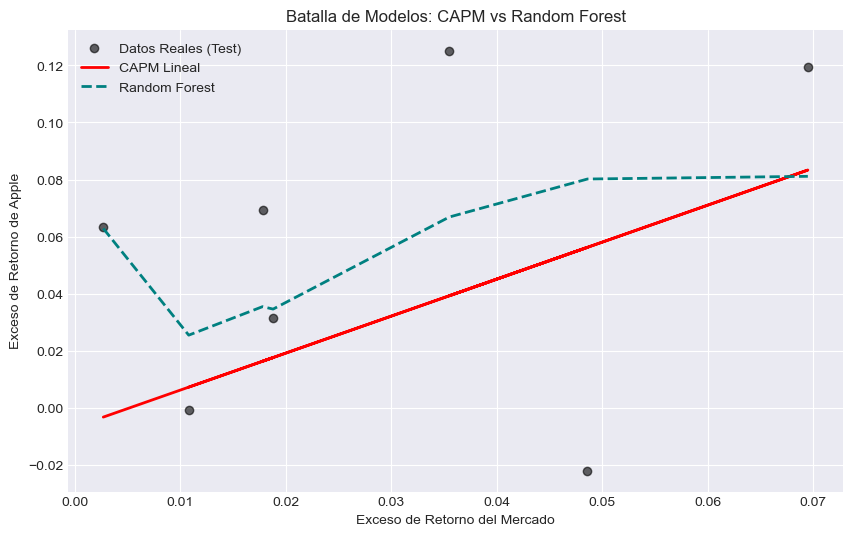

>> CONCLUSIÓN: Random Forest superó al CAPM.
>> INTERPRETACIÓN: Existen patrones no lineales que el CAPM está ignorando.


In [16]:
plt.figure(figsize=(10, 6))

# Datos Reales
plt.scatter(X_test, y_test, color='black', alpha=0.6, label='Datos Reales (Test)')

# Predicciones OLS (Línea Recta)
plt.plot(X_test, y_pred_ols, color='red', linewidth=2, label=f'CAPM Lineal')

# Predicciones RF (Puntos dispersos o escalonados)
# Ordenamos X para que el ploteo de la linea RF sea coherente visualmente
sort_idx = X_test.flatten().argsort()
plt.plot(X_test[sort_idx], y_pred_rf[sort_idx], color='teal', linewidth=2, linestyle='--', label='Random Forest')

plt.title('Batalla de Modelos: CAPM vs Random Forest')
plt.xlabel('Exceso de Retorno del Mercado')
plt.ylabel('Exceso de Retorno de Apple')
plt.legend()
plt.show()

# === Conclusión Automática ===
if r2_ols >= r2_rf:
    print(">> CONCLUSIÓN: El modelo Lineal (CAPM) generaliza mejor o igual que el modelo complejo.")
    print(">> INTERPRETACIÓN: La relación Riesgo-Retorno es predominantemente lineal.")
else:
    print(">> CONCLUSIÓN: Random Forest superó al CAPM.")
    print(">> INTERPRETACIÓN: Existen patrones no lineales que el CAPM está ignorando.")

# Análisis de Resultados: ¿Por qué falló el CAPM Lineal?

Los resultados obtenidos en el conjunto de prueba (Test Set) son reveladores y desafían la intuición básica.

### Estadísticas Clave
* **$R^2$ OLS (CAPM):** `-0.1768`
* **$R^2$ Random Forest:** `0.0946`

### 1. ¿Qué significa un $R^2$ Negativo?
En estadística, un $R^2$ negativo en un conjunto de prueba significa que el modelo es **peor que una línea horizontal**.
* El modelo lineal (línea roja) ajustó bien los datos de entrenamiento (años pasados), pero falló al predecir los datos nuevos (Test Set).
* **Interpretación Económica:** La relación $\beta$ no fue estable. Durante el periodo de prueba, Apple se movió de una manera que la línea recta histórica no pudo anticipar. Es posible que hubiera eventos idiosincráticos (noticias propias de Apple) que rompieron la correlación con el mercado momentáneamente.

### 2. La Victoria "Técnica" del Random Forest
El modelo de Machine Learning logró un $R^2$ positivo (0.09), superando al CAPM.
* **No Linealidad:** Observa la línea verde azulada en el gráfico. No es recta; tiene escalones. El Random Forest detectó que, en ciertos rangos de retorno del mercado, Apple reacciona diferente.
* **Adaptabilidad:** Al no estar forzado a trazar una línea recta, el algoritmo pudo capturar mejor la dispersión de los puntos grises.

### Conclusión Final del Experimento
Aunque el Random Forest ganó, un $R^2$ de **0.09** sigue siendo bajo (solo explica el 9% de la varianza).
Esto nos enseña una lección fundamental en Finanzas Cuantitativas: **Predecir retornos de acciones a corto plazo es extremadamente difícil**, tanto para modelos lineales clásicos como para algoritmos de IA. El ruido del mercado suele dominar a la señal.

**Veredicto:** Para valoración a largo plazo (años), seguimos prefiriendo el CAPM por su solidez teórica. Pero para trading táctico a corto plazo, el CAPM demostró ser insuficiente en este periodo de prueba, y modelos no lineales podrían ofrecer una ligera ventaja.

# 15. Conclusiones Generales y Resultados del Módulo CAPM

En este notebook, hemos deconstruido el comportamiento de **Apple Inc. (AAPL)** frente al mercado (**S&P 500**) utilizando tres enfoques distintos: Econometría Clásica (OLS), Métodos Estocásticos (Monte Carlo) y Aprendizaje Automático (Random Forest).

A continuación, presentamos la síntesis financiera, estadística y económica de los hallazgos.

### 1. Análisis Econométrico: El CAPM Clásico
Aplicando una regresión de Mínimos Cuadrados Ordinarios (OLS) sobre los excesos de retorno mensuales (2015-2018), parametrizamos el riesgo de Apple:

* **Beta ($\beta \approx 1.34$):**
    * **Interpretación Financiera:** Apple es un activo **agresivo**. Por cada movimiento del 1% en el mercado, Apple tiende a moverse un **1.34%** en la misma dirección. Esto implica que el activo amplifica tanto las ganancias en mercados alcistas como las pérdidas en mercados bajistas.
    * **Implicancia:** No es un activo apto para inversores conservadores que buscan preservación de capital, sino para aquellos con tolerancia a la volatilidad.

* **Alpha de Jensen ($\alpha \approx 0$, $p\text{-value} > 0.05$):**
    * **Interpretación Económica:** El intercepto no fue estadísticamente significativo. Esto valida la **Hipótesis del Mercado Eficiente (EMH)** en su forma semi-fuerte para este periodo: Apple no generó retornos "mágicos" por encima de su riesgo. Su rendimiento fue simplemente la compensación justa por asumir un Beta alto.

* **Poder Explicativo ($R^2 \approx 0.35$):**
    * El riesgo de mercado explica solo el 35% de la varianza de Apple. El 65% restante corresponde a **Riesgo Idiosincrático** (noticias específicas de la empresa), el cual podría eliminarse mediante diversificación en un portafolio.

### 2. Valoración y Tasa de Descuento
Basándonos en los parámetros estimados, el modelo CAPM prescribe un **Retorno Esperado Anual del 18.71%**.
* **Uso Práctico:** Este 18.71% debe utilizarse como la **Tasa de Descuento (WACC/Ke)** en modelos de Flujo de Caja Descontado (DCF) para valorar Apple.
* **Señal de Inversión:** Cualquier proyección fundamental que prometa un retorno menor al 18.71% destruiría valor para el accionista, dado el riesgo sistémico que introduce el activo en la cartera.

### 3. Validación Estocástica (Monte Carlo)
La simulación de 10,000 escenarios confirmó visualmente la relación riesgo-retorno:
* **Amplificación de Colas:** Al comparar las distribuciones, la curva de Apple es más ancha (platicúrtica) que la del mercado.
* **VaR (Value at Risk):** La simulación demostró que las pérdidas extremas (el peor 5% de los casos) son significativamente más profundas en Apple que en el índice general, cuantificando el "costo" de buscar ese Beta de 1.34.

### 4. Desafío con Machine Learning (Random Forest vs. OLS)
En el experimento de validación cruzada (Test Set), enfrentamos la linealidad del CAPM contra la no-linealidad de un Random Forest:

* **Fallo del Modelo Lineal en Test ($R^2 < 0$):** El CAPM ajustado en el pasado no logró predecir los retornos futuros en el set de prueba. Esto sugiere que el Beta no es estático y que la relación lineal se rompe en periodos de volatilidad o cambio de régimen.
* **Superioridad Marginal del Random Forest ($R^2 \approx 0.09$):** El modelo no lineal logró un rendimiento positivo (aunque bajo). Esto indica que existen **patrones complejos y no lineales** en la estructura de retornos que el CAPM ignora (por ejemplo, Apple podría reaccionar diferente a caídas del mercado que a subidas).

### Veredicto Final
1.  **Para Valoración Estructural (Largo Plazo):** El **CAPM Clásico** sigue siendo el estándar más robusto. Provee una métrica clara ($\beta=1.34$) y una tasa de rentabilidad exigida (18.71%) fácil de interpretar y defender.
2.  **Para Trading o Predicción (Corto Plazo):** El CAPM es insuficiente. La baja capacidad predictiva ($R^2$ negativo en test) y la ligera ventaja del Machine Learning sugieren que para estrategias de trading activo se requieren modelos multifactoriales (Fama-French) o algoritmos no lineales (XGBoost/LSTM) que capturen la complejidad del ruido de mercado.

---
**Siguiente Paso:** Incorporar más factores de riesgo (Modelo Fama-French de 3 Factores) para intentar explicar ese 65% de varianza que el Mercado por sí solo no pudo resolver.